In [208]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
import folium
import branca.colormap as cm
import warnings
warnings.filterwarnings('ignore')

In [153]:
# import data
df_og = pd.read_csv("state_okuns_rates.csv", index_col = 'states')
df = df_og.drop(['Unnamed: 0', "state.abb"], axis = 1)
df.head()

,rmse,avg_pop_gr,avg_pce_gr,med_bach%,avg_rmedinc_gr
states,,,,,
Alabama,4.424976,0.834621,4.694042,23.5,0.821233
Alaska,12.943088,2.318390,4.943644,28.0,0.238324
Arizona,13.265409,3.327789,5.900534,27.6,0.796403
Arkansas,3.941165,0.689319,5.387595,21.4,0.807923
California,7.857731,2.653571,5.789248,31.7,0.753564


In [150]:
df_c = df - np.mean(df, axis = 0) #center the data
df_sc = df_c / np.std(df, axis = 0) #scale the data 
df_sc.head()

,rmse,avg_pop_gr,avg_pce_gr,med_bach%,avg_rmedinc_gr
states,,,,,
Alabama,-0.701580,-0.578267,-0.246035,-1.179798,0.387283
Alaska,0.687520,1.405241,0.088475,-0.266642,-1.944709
Arizona,0.740083,2.754610,1.370871,-0.347811,0.287948
Arkansas,-0.780478,-0.772507,0.683445,-1.605938,0.334031
California,-0.141780,1.853313,1.221729,0.484176,0.116563


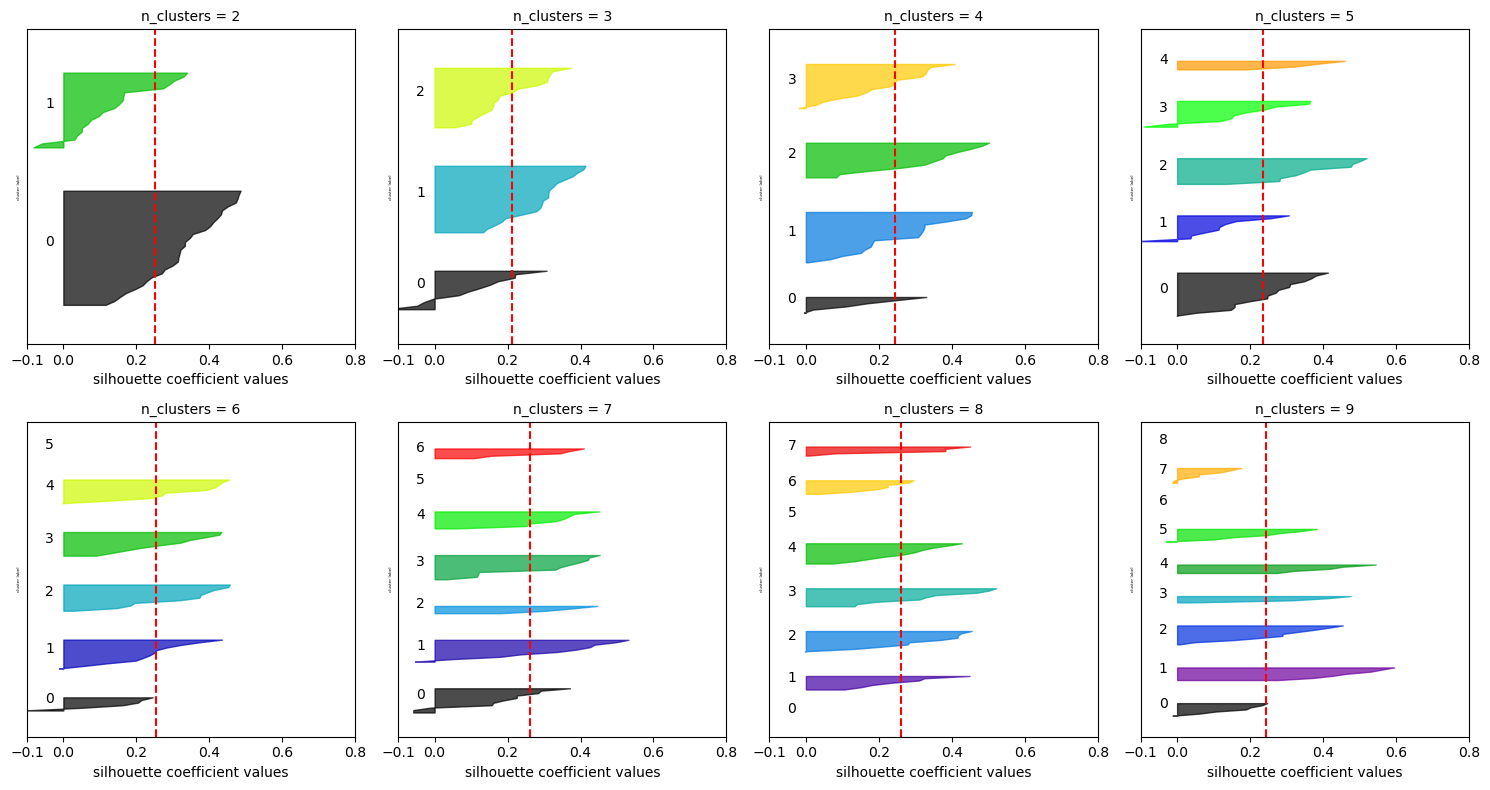

In [79]:
# do silhouette analysis to determine number of clusters

X = df_sc.to_numpy()
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
inertia = []

plt.figure(figsize = (15, 8))
for n_clusters in range_n_clusters:
    datapoints = plt.subplot(2, 4, range_n_clusters.index(n_clusters)+1) # create grid of subplots (2 rows, 4 per row)
    datapoints.set_xlim([-0.1, 0.8])
    datapoints.set_ylim([0, len(X) + (n_clusters + 1)*10])

    # initialize clusterer
    clusterer = cluster.KMeans(n_clusters = n_clusters, random_state = 3)
    cluster_labels = clusterer.fit_predict(X)
    inertia += [clusterer.inertia_]

    # silhouette score gives avg value for all samples (density + separation of clusters)
    silhouette_avg = silhouette_score(X, cluster_labels)

    # find silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # aggregate and sort silhouette values for each cluster i 
        i_cluster_values = sample_silhouette_values[cluster_labels == i]
        i_cluster_values.sort()
        size_cluster_i = i_cluster_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        datapoints.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            icluster_values,
            facecolor = color,
            edgecolor = color,
            alpha = 0.7,
        )

        # label each plot with cluster number
        datapoints.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # reassign new y_lower 
        y_lower = y_upper + 10  

    datapoints.set_title("n_clusters = %d"% n_clusters, fontsize=10)
    datapoints.set_xlabel("silhouette coefficient values", fontsize=10)
    datapoints.set_ylabel("cluster label", fontsize=3)

    datapoints.axvline(x = silhouette_avg, color = "red", linestyle = "--")

    datapoints.set_yticks([])  
    datapoints.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])


plt.tight_layout()
plt.show()

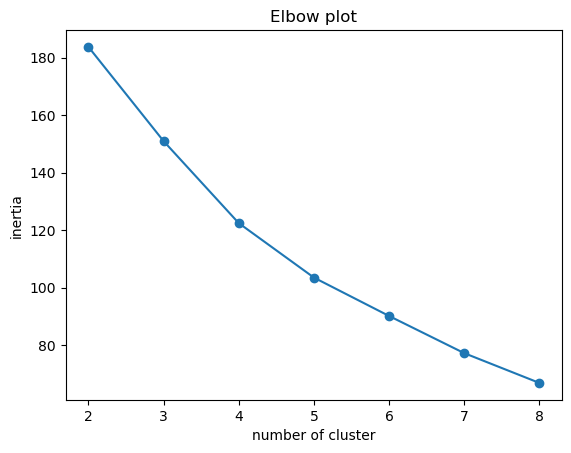

In [51]:
# look at elbow plot 
plt.plot(range_n_clusters, inertia)
plt.scatter(range_n_clusters, inertia)
plt.title("Elbow plot")
plt.xlabel("number of cluster")
plt.ylabel("inertia")
plt.xticks(range_n_clusters);

# inconclusive, use silhouette scores instead 

In [101]:
# decide on 5 clusters of states
kmeans = cluster.KMeans(n_clusters = 5, random_state = 3).fit(df_sc)
kmeans.labels_

array([2, 1, 1, 2, 1, 3, 0, 4, 1, 3, 4, 1, 0, 2, 0, 0, 2, 2, 0, 3, 0, 2,
       0, 2, 0, 3, 0, 1, 0, 0, 1, 0, 1, 4, 2, 1, 3, 0, 0, 2, 3, 3, 1, 3,
       0, 3, 3, 2, 0, 4])

In [155]:
# label clusters
labeled = pd.Series(kmeans.labels_, name = "cluster", index  = df.index).to_frame()
labeled.head()

,cluster
states,
Alabama,2
Alaska,1
Arizona,1
Arkansas,2
California,1


In [247]:
# print out clusters 
for c in range(5):
    print(f">>> Cluster {c}:")
    print(list(labeled.query(f'cluster == {c}').index))
    print()

>>> Cluster 0:
['Connecticut', 'Illinois', 'Iowa', 'Kansas', 'Maine', 'Massachusetts', 'Minnesota', 'Missouri', 'Nebraska', 'New Hampshire', 'New Jersey', 'New York', 'Pennsylvania', 'Rhode Island', 'Vermont', 'Wisconsin']

>>> Cluster 1:
['Alaska', 'Arizona', 'California', 'Florida', 'Idaho', 'Nevada', 'New Mexico', 'North Carolina', 'Oklahoma', 'Texas']

>>> Cluster 2:
['Alabama', 'Arkansas', 'Indiana', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi', 'Ohio', 'South Carolina', 'West Virginia']

>>> Cluster 3:
['Colorado', 'Georgia', 'Maryland', 'Montana', 'Oregon', 'South Dakota', 'Tennessee', 'Utah', 'Virginia', 'Washington']

>>> Cluster 4:
['Delaware', 'Hawaii', 'North Dakota', 'Wyoming']



In [141]:
# create geojson object 
import json
opened = open("us-states.json")
map_data = json.load(opened)
#for i in map_data["features"]:
    #print(i)

In [203]:
# prepare data for graphing
labeled_abb = labeled.reset_index(drop = True)
labeled_abb["state.abb"] = df_og["state.abb"].values

In [319]:
# create choropleth graph 
m = folium.Map(location = [40, -95], zoom_start = 4)

folium.Choropleth(
    geo_data = map_data,
    name = "choropleth",
    data = labeled_abb,
    columns = labeled_abb.columns[[1, 0]],
    key_on = "feature.id",
    legend_name = "Cluster", 
    fill_color="Spectral"
).add_to(m)

folium.LayerControl().add_to(m)
m


### NOTE: even though there are 6 colours on the scale, only 5 are used. 

# to view the map without downloading the file, paste the link of this notebook into https://nbviewer.org/